<a href="https://colab.research.google.com/github/Miragecore/SandBox/blob/devel/Colab/Stitching/stitching_two_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
#구글 드라이브 마운트
from google.colab import drive

drive.mount('/content/drive')


Mounted at /content/drive


In [6]:
#드라이브안에서 프로젝트 드라이브로 이동
import os;
root_path = '/content/drive/MyDrive/SandBox/Stitch/earring'

os.chdir(root_path);

print(os.getcwd())

/content/drive/MyDrive/SandBox/Stitch/earring


In [7]:
#from IPython.display import Image, display
import cv2, numpy as np

#Colab에서 imShow를 사용하기 위해 cv2_imshow를 사용한다.
from google.colab.patches import cv2_imshow

#SIFT or SURF는 4.3이상의 버전에서만 사용가능하다. 
if cv2.__version__ != "4.4.0":
  print(cv2.__version__)
  #설치후에는 런타임을 재시작해줘야 한다.
  !pip install opencv-contrib-python==4.4.0.44


In [79]:
#먼저 업로드해둔 이미지 파일들
image_files = [
    'earring_1.jpg',
    'earring_2.jpg',
    'earring_3.jpg']

img1 = cv2.imread(image_files[0])
img2 = cv2.imread(image_files[1])
img3 = cv2.imread(image_files[2])

#cv2_imshow(img1)
#cv2_imshow(img2)
#cv2_imshow(img3)

In [80]:
#최소 매치수 확인
MIN_MATCH_COUNT = 10

# Initiate SIFT detector
sift = cv2.SIFT_create()

#흑백 이미지 생성
gray1 = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)

#이미지에서 0인 영역으로 마스크를 생성시켜 계산의 속도 향상, 검은 영역이 없다면 무쓸모
_, mask1 = cv2.threshold(gray1, 1, 255, cv2.THRESH_BINARY)
_, mask2 = cv2.threshold(gray2, 1, 255, cv2.THRESH_BINARY)

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(gray1, mask1)
kp2, des2 = sift.detectAndCompute(gray2, mask2)

FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1,des2,k=2)

# store all the good matches as per Lowe's ratio test.
# 2번째 후보와 거리가 0.7 이상인 포인트를 좋은 매치로 분류
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)


In [113]:
# 최소 매치수 확인(10개)
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

    # 변환 매트릭스를 찾고
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)

    # 1차원 배열로 변환
    matchesMask = mask.ravel().tolist()

    h1, w1 = gray1.shape
    h2, w2 = gray2.shape

    #reshape는 언제나 어렵다..
    corner1 = np.float32([ [0,0],[0,h1],[w1,h1],[w1,0]])
    corner2 = np.float32([ [0,0],[0,h2],[w2,h2],[w2,0]]).reshape(-1,1,2)
    corner1 = corner1.reshape(-1,1,2)

    #변환후 img1의 크기
    tr_corner1 = cv2.perspectiveTransform(corner1,M)
    
    #img2의 크기
    corner_after_tr = np.concatenate((tr_corner1, corner2), axis=0)

    #두 이미지를 합쳤을때 이미지 크기 계산
    [xmin, ymin] = np.int32(corner_after_tr.min(axis=0).ravel() - 0.5)
    [xmax, ymax] = np.int32(corner_after_tr.max(axis=0).ravel() + 0.5)

    #매칭 영역 사각형 그리기
    #img2 원본 유지를 위해 복사
    img2_match_area = img2.copy()
    img2_match_area = cv2.polylines(img2_match_area,[np.int32(tr_corner1)],True,255,1, cv2.LINE_AA)
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None

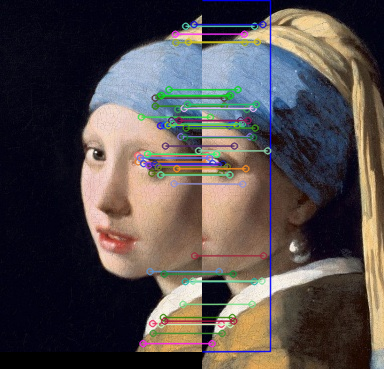

In [114]:
#draw_params = dict(matchColor = (0,255,0), # draw matches in green color
#                   singlePointColor = None,
#                   matchesMask = matchesMask, # draw only inliers
#                   flags = 2)
#매칭 포인트 그리기
img3 = cv2.drawMatches(img1,kp1,img2_match_area,kp2,good,None,matchesMask = matchesMask,\
                       flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)

cv2_imshow(img3)

변환 행렬이 img1을 (-xmin, -ymin) 만큼 평행이동시키도록 변환  
$H_t =
 \begin{pmatrix}
  1 & 0 & -xmin \\
  0 & 1 & -ymin \\
  0  & 0  & 1 \\
 \end{pmatrix}$
 

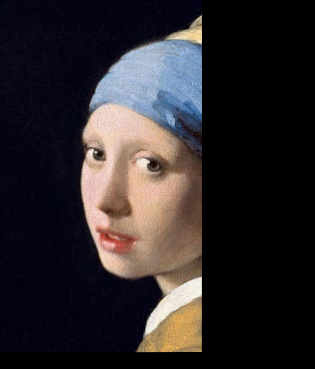

In [126]:
t = [-xmin,-ymin]
#warp된 만큼 X-Y 평행이동
Ht = np.array([[1,0,t[0]],[0,1,t[1]],[0,0,1]]) # translate
Ht = Ht.dot(M)

warpedimg = cv2.warpPerspective(img1, Ht,((xmax-xmin), (ymax-ymin)))
cv2_imshow(warpedimg)

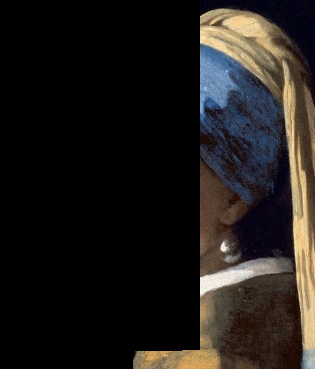

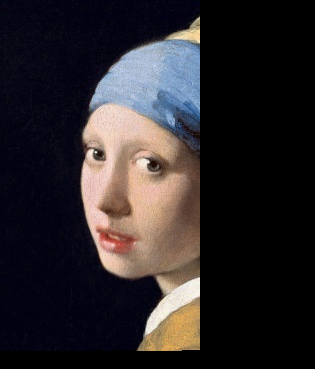

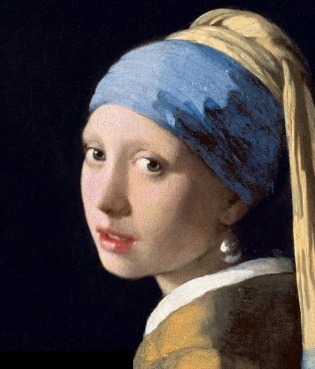

In [125]:
#와핑된 크기의 이미지에 img2를 와핑된 영역으로 복사
resizedB = np.zeros((warpedimg.shape[0], warpedimg.shape[1], 3), np.uint8)

#Column, Row -> Height, Width 이게 볼때마다 헷갈림
resizedB[t[1]:t[1]+h2,t[0]:t[0]+w2] = img2

# Now create a mask of logo and create its inverse mask also
warpedGray = cv2.cvtColor(warpedimg,cv2.COLOR_BGR2GRAY)

#와핑된 이미지로 마스크 생성
ret, mask = cv2.threshold(warpedGray, 0, 255, cv2.THRESH_BINARY)

#마스크 리파인
kernel = np.ones((5,5),np.uint8)
k1 = (kernel == 1).astype('uint8')
mask = cv2.erode(mask, k1, borderType=cv2.BORDER_CONSTANT)

#마스크 반전 - img2에 대한 마스크 생성
mask_inv = cv2.bitwise_not(mask)

#와핑된 이미지 마스크로 중복 영역 제거
difference = cv2.bitwise_or(resizedB, resizedB, mask=mask_inv)
cv2_imshow(difference)

# Mask erode로 포함된 img2의 영역을 img1에서 제거
result2 = cv2.bitwise_and(warpedimg, warpedimg, mask=mask)
cv2_imshow(result2)

#결과물 합치기
result = cv2.add(result2, difference)

cv2_imshow(result)